In [359]:
from numpy import loadtxt
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.python.keras.layers import Dropout, BatchNormalization, Flatten
from keras import regularizers

from tensorflow.keras.layers import Dense
from sklearn import preprocessing 
% pylab inline

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


,ID,appearedTimeOfDay,appearedHour,appearedMinute,terrainType,closeToWater,city,continent,weather,temperature,...,cooc_143,cooc_144,cooc_145,cooc_146,cooc_147,cooc_148,cooc_149,cooc_150,cooc_151,class
0,NzM4OTYzMzQxNTMyNzc1MDQ0NQ==,evening,19,10,13,False,Bangkok,Asia,Clear,27.8,...,False,False,False,False,False,False,False,False,False,2
1,NDEwMjE0MzYwNzUyMjE2OTI0NQ==,night,5,19,13,True,New_York,America,Clear,26.1,...,False,False,False,False,False,False,False,False,False,5
2,OTQ3NzU5MTA4MzgzODg2NzYxMw==,evening,19,46,0,True,New_York,America,Clear,24.7,...,False,False,False,False,False,False,False,False,False,3
3,MTU2OTA5MTcyMDMzOTc0NzczODk=,morning,11,10,0,True,Hobart,Australia,Clear,12.7,...,False,False,False,False,False,False,False,False,False,4
4,NTE2OTkxNjE3OTUzODY0MTE4MQ==,evening,18,32,13,True,Los_Angeles,America,PartlyCloudy,19.1,...,False,False,False,False,False,False,False,False,False,3


In [360]:
test.head()

,id,appearedTimeOfDay,appearedHour,appearedMinute,terrainType,closeToWater,city,continent,weather,temperature,...,cooc_142,cooc_143,cooc_144,cooc_145,cooc_146,cooc_147,cooc_148,cooc_149,cooc_150,cooc_151
0,MTA5MTEwOTYxMzM0NzA2NDEzNzM=,morning,8,26,13,False,Ljubljana,Europe,MostlyCloudy,16.8,...,False,False,False,False,False,False,False,False,False,False
1,MTY0OTUyMTM2MDExMjg3MjczMjU=,night,2,35,13,True,Los_Angeles,America,PartlyCloudy,18.6,...,False,False,False,False,False,True,False,False,False,False
2,MTQ0ODU1OTEzOTU1NTAyNzI4NjE=,night,0,5,0,True,New_York,America,PartlyCloudy,30.0,...,False,False,False,False,False,False,False,False,False,False
3,MTY1ODg1MzEwNzYzNDUzMDUwNTM=,morning,7,38,13,True,London,Europe,MostlyCloudy,18.5,...,False,False,False,False,False,False,False,False,False,False
4,MTY0NTg2OTA5MTkzOTE2MTc1MTc=,night,1,27,12,False,Chicago,America,Clear,20.2,...,False,False,False,False,False,False,False,False,False,False


In [361]:
y_label = train.loc[:, ['class']]
test_id = test.iloc[:, 0]
print(test_id[:5])

0    MTA5MTEwOTYxMzM0NzA2NDEzNzM=
1    MTY0OTUyMTM2MDExMjg3MjczMjU=
2    MTQ0ODU1OTEzOTU1NTAyNzI4NjE=
3    MTY1ODg1MzEwNzYzNDUzMDUwNTM=
4    MTY0NTg2OTA5MTkzOTE2MTc1MTc=
Name: id, dtype: object


In [362]:
def my_min_max_normalization(train, test):
    for i in range(len(train.iloc[0, :])):
        col = train.iloc[0, i]
        if (type(col) is numpy.int64 or type(col) is numpy.float64):
            train.iloc[:, i] = train.iloc[:, i] / train.iloc[:, i].max()
            
    if (test is not None) :
        for i in range(len(test.iloc[0, :])):
            col = test.iloc[0, i]
            if (type(col) is numpy.int64 or type(col) is numpy.float64):
                test.iloc[:, i] = test.iloc[:, i] / test.iloc[:, i].max()
    
    if (test is not None) :
        return (train, test)
    else:
        return train

In [363]:
def my_std_normalization(train, test):
    for i in range(len(train.iloc[0, :])):
        col = train.iloc[0, i]
        
        if (type(col) is numpy.int64 or type(col) is numpy.float64):
            std = train.iloc[:, i].std()
            mean = train.iloc[:, i].mean()
            train.iloc[:, i] = (train.iloc[:, i] - mean) / std
            
    if (test is not None) :
        for i in range(len(test.iloc[0, :])):
            col = test.iloc[0, i]
            
            if (type(col) is numpy.int64 or type(col) is numpy.float64):
                std = test.iloc[:, i].std()
                mean = test.iloc[:, i].mean()
                test.iloc[:, i] = (test.iloc[:, i] - mean) / std
    
    if (test is not None) :
        return (train, test)
    else:
        return train
    

In [364]:
def my_one_hot_encoding(train, test, col_name, debug=False):
    col_value_unique = train.loc[:, col_name].sort_values(ascending=True).unique()
    mapping = {}
    i = 0
    
    #find unique value
    for item in range(col_value_unique.size):
        if col_value_unique[item] not in mapping:
            mapping[col_value_unique[item]] = i
            i += 1
            
    if (test is not None) :
        col_value_unique = test.loc[:, col_name].sort_values(ascending=True).unique()
        for item in range(col_value_unique.size):
            if col_value_unique[item] not in mapping:
                mapping[col_value_unique[item]] = i
                i += 1
           
    #original
    train_col_ori = train[col_name]
    if (test is not None) :
        test_col_ori = test[col_name]
    
    #label encoding
    train[col_name] = train[col_name].map(mapping)
    if (test is not None) :
        test[col_name] = test[col_name].map(mapping)

    #one-hot encoding
    train_one_hot = np.zeros((len(train), len(mapping)))
    train_one_hot[np.arange(len(train)), train[col_name]] = 1
    train_one_hot_df = pd.DataFrame(train_one_hot, columns=mapping)
    
    if (test is not None) :
        test_one_hot = np.zeros((len(test), len(mapping)))
        test_one_hot[np.arange(len(test)), test[col_name]] = 1
        test_one_hot_df = pd.DataFrame(test_one_hot, columns=mapping)
    
    if (debug == True):
        train_one_hot_df = pd.concat([train_col_ori, train_one_hot_df], axis=1)
        if (test is not None) :
            test_one_hot_df = pd.concat([test_col_ori, test_one_hot_df], axis=1)
    
    if (test is not None) :
        return (train_one_hot_df, test_one_hot_df)
    else:
        return train_one_hot_df

In [365]:
def my_boolean_encoding(train, test):
    boolean_mapping = {False:0, True:1}

    for i in range(len(train.iloc[0, :])):
        col = train.iloc[0, i]
        if (type(col) is numpy.bool_):
            train.iloc[:, i] = train.iloc[:, i].map(boolean_mapping)
            
    if (test is not None) :
        for i in range(len(test.iloc[0, :])):
            col = test.iloc[0, i]
            if (type(col) is numpy.bool_):
                test.iloc[:, i] = test.iloc[:, i].map(boolean_mapping)
    
    if (test is not None) :
        return (train, test)
    else:
        return train

In [366]:
y_label_one_hot = my_one_hot_encoding(y_label.copy(), None, 'class')

if 'class' in train.columns:
    train = train.drop('class', axis=1)

if 'ID' in train.columns:
    train = train.drop('ID', axis=1)
    
if 'id' in test.columns:
    test = test.drop('id', axis=1)
    

#if 'appearedHour' in train.columns:
#    train = train.drop('appearedHour', axis=1)
#    test = test.drop('appearedHour', axis=1)
    
#if 'appearedMinute' in train.columns:
#    train = train.drop('appearedMinute', axis=1)
#    test = test.drop('appearedMinute', axis=1)
    
train.head()

,appearedTimeOfDay,appearedHour,appearedMinute,terrainType,closeToWater,city,continent,weather,temperature,windSpeed,...,cooc_142,cooc_143,cooc_144,cooc_145,cooc_146,cooc_147,cooc_148,cooc_149,cooc_150,cooc_151
0,evening,19,10,13,False,Bangkok,Asia,Clear,27.8,9.00,...,False,False,False,False,False,False,False,False,False,False
1,night,5,19,13,True,New_York,America,Clear,26.1,8.70,...,False,False,False,False,False,False,False,False,False,False
2,evening,19,46,0,True,New_York,America,Clear,24.7,16.82,...,False,False,False,False,False,False,False,False,False,False
3,morning,11,10,0,True,Hobart,Australia,Clear,12.7,13.25,...,False,False,False,False,False,False,False,False,False,False
4,evening,18,32,13,True,Los_Angeles,America,PartlyCloudy,19.1,5.78,...,False,False,False,False,False,False,False,False,False,False


In [367]:
test.head()

,appearedTimeOfDay,appearedHour,appearedMinute,terrainType,closeToWater,city,continent,weather,temperature,windSpeed,...,cooc_142,cooc_143,cooc_144,cooc_145,cooc_146,cooc_147,cooc_148,cooc_149,cooc_150,cooc_151
0,morning,8,26,13,False,Ljubljana,Europe,MostlyCloudy,16.8,2.69,...,False,False,False,False,False,False,False,False,False,False
1,night,2,35,13,True,Los_Angeles,America,PartlyCloudy,18.6,13.00,...,False,False,False,False,False,True,False,False,False,False
2,night,0,5,0,True,New_York,America,PartlyCloudy,30.0,9.15,...,False,False,False,False,False,False,False,False,False,False
3,morning,7,38,13,True,London,Europe,MostlyCloudy,18.5,2.87,...,False,False,False,False,False,False,False,False,False,False
4,night,1,27,12,False,Chicago,America,Clear,20.2,5.46,...,False,False,False,False,False,False,False,False,False,False


In [368]:
train, test = my_std_normalization(train, test)
train, test = my_min_max_normalization(train, test)


train.head()

,appearedTimeOfDay,appearedHour,appearedMinute,terrainType,closeToWater,city,continent,weather,temperature,windSpeed,...,cooc_142,cooc_143,cooc_144,cooc_145,cooc_146,cooc_147,cooc_148,cooc_149,cooc_150,cooc_151
0,evening,0.674412,-0.728642,0.518709,False,Bangkok,Asia,Clear,0.252388,0.030126,...,False,False,False,False,False,False,False,False,False,False
1,night,-0.465145,-0.411136,0.518709,True,New_York,America,Clear,0.157542,0.023952,...,False,False,False,False,False,False,False,False,False,False
2,evening,0.674412,0.541381,-1.566883,True,New_York,America,Clear,0.079433,0.191051,...,False,False,False,False,False,False,False,False,False,False
3,morning,0.023237,-0.728642,-1.566883,True,Hobart,Australia,Clear,-0.590070,0.117585,...,False,False,False,False,False,False,False,False,False,False
4,evening,0.593015,0.047483,0.518709,True,Los_Angeles,America,PartlyCloudy,-0.233001,-0.036138,...,False,False,False,False,False,False,False,False,False,False


In [369]:
train, test = my_boolean_encoding(train.copy(), test.copy())
train.head()
#train.to_csv("train_bool.csv", index=0)
#test.to_csv("test_bool.csv", index=0)

,appearedTimeOfDay,appearedHour,appearedMinute,terrainType,closeToWater,city,continent,weather,temperature,windSpeed,...,cooc_142,cooc_143,cooc_144,cooc_145,cooc_146,cooc_147,cooc_148,cooc_149,cooc_150,cooc_151
0,evening,0.674412,-0.728642,0.518709,0,Bangkok,Asia,Clear,0.252388,0.030126,...,0,0,0,0,0,0,0,0,0,0
1,night,-0.465145,-0.411136,0.518709,1,New_York,America,Clear,0.157542,0.023952,...,0,0,0,0,0,0,0,0,0,0
2,evening,0.674412,0.541381,-1.566883,1,New_York,America,Clear,0.079433,0.191051,...,0,0,0,0,0,0,0,0,0,0
3,morning,0.023237,-0.728642,-1.566883,1,Hobart,Australia,Clear,-0.590070,0.117585,...,0,0,0,0,0,0,0,0,0,0
4,evening,0.593015,0.047483,0.518709,1,Los_Angeles,America,PartlyCloudy,-0.233001,-0.036138,...,0,0,0,0,0,0,0,0,0,0


In [370]:
one_hot_list = ['appearedTimeOfDay', 'city', 'continent', 'weather', 'weatherIcon']

for col in train.columns:
    if col in one_hot_list:
        train_col_one_hot, test_col_one_hot = my_one_hot_encoding(train.copy(), test.copy(), col)
        train = pd.concat([train, train_col_one_hot.iloc[:, 1:]], axis=1)
        test = pd.concat([test, test_col_one_hot.iloc[:, 1:]], axis=1)
        train = train.drop(col, axis=1)
        test = test.drop(col, axis=1)

#train.to_csv("train_bool.csv", index=0)
#test.to_csv("test_bool.csv", index=0)
train.head()

,appearedHour,appearedMinute,terrainType,closeToWater,temperature,windSpeed,pressure,population_density,urban,suburban,...,WindyandFoggy,WindyandPartlyCloudy,RainandWindy,clear-night,cloudy,fog,partly-cloudy-day,partly-cloudy-night,rain,wind
0,0.674412,-0.728642,0.518709,0,0.252388,0.030126,-0.308256,0.529839,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.465145,-0.411136,0.518709,1,0.157542,0.023952,0.210687,-0.181026,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.674412,0.541381,-1.566883,1,0.079433,0.191051,0.431757,-0.181026,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.023237,-0.728642,-1.566883,1,-0.590070,0.117585,-0.036849,-0.165803,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.593015,0.047483,0.518709,1,-0.233001,-0.036138,-0.183709,0.313634,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [371]:
y_label_one_hot.head()

,0,1,2,3,4,5
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0


In [372]:
y_label.head()

,class
0,2
1,5
2,3
3,4
4,3


In [373]:
x_train, x_valid, y_train, y_valid = train_test_split(train, y_label_one_hot, random_state = 4, test_size = 0.13, stratify=y_label)

In [374]:
y_valid.head()

,0,1,2,3,4,5
5045,0.0,0.0,1.0,0.0,0.0,0.0
2600,0.0,0.0,1.0,0.0,0.0,0.0
2160,0.0,0.0,0.0,0.0,1.0,0.0
5314,1.0,0.0,0.0,0.0,0.0,0.0
2831,0.0,0.0,1.0,0.0,0.0,0.0


In [375]:
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)
print(x_train.iloc[0,:].size)
print(y_train.iloc[0,:].size)

(6229, 293)
(931, 293)
(6229, 6)
(931, 6)
293
6


In [376]:
x_valid.head()

,appearedHour,appearedMinute,terrainType,closeToWater,temperature,windSpeed,pressure,population_density,urban,suburban,...,WindyandFoggy,WindyandPartlyCloudy,RainandWindy,clear-night,cloudy,fog,partly-cloudy-day,partly-cloudy-night,rain,wind
5045,-0.790733,0.717773,0.679140,0,-0.121418,-0.054658,0.290605,-0.155735,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2600,0.837206,-0.093631,-0.764732,0,-0.255318,0.247231,0.067978,-0.051717,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2160,0.430221,0.259153,-1.566883,1,-0.311110,0.092068,0.070054,0.231610,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5314,-0.790733,0.435545,0.518709,0,0.453239,-0.078530,-0.175925,0.116712,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2831,-0.709336,-0.446415,-0.925162,0,-0.110259,-0.052806,0.363776,-0.176079,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [377]:
y_train.head()

,0,1,2,3,4,5
6708,0.0,0.0,0.0,0.0,0.0,1.0
2039,0.0,1.0,0.0,0.0,0.0,0.0
2568,0.0,0.0,0.0,0.0,1.0,0.0
616,0.0,0.0,0.0,0.0,1.0,0.0
5832,0.0,0.0,0.0,0.0,0.0,1.0


In [378]:
#y_train.iloc[:,-1].values.shape

In [379]:
#x_train.head()

In [380]:
input_shape = x_train.iloc[0,:].size
output_shape = y_train.iloc[0,:].size

model = tf.keras.Sequential()
model.add(Dense(293, activation='relu', input_shape=(input_shape,), kernel_regularizer=regularizers.l2(0.005)))
model.add(Dropout(0.65))
#model.add(BatchNormalization())
model.add(Dense(output_shape, activation='softmax')) 

batch_size = 32
epochs = 300
lr = 0.01
train_ratio = 0.9

early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=2)


In [381]:
model.compile(
              loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.8, beta_2=0.899, epsilon=None, decay=0.0, amsgrad=True),
              #optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy']
            )

In [382]:
model_history = model.fit(x=x_train, y=y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_valid, y_valid),
                          shuffle=False, callbacks=[early_stopping]
                         )

Train on 6229 samples, validate on 931 samples
Epoch 1/300
6229/6229 [==============================] - 1s 212us/step - loss: 2.0652 - acc: 0.3749 - val_loss: 1.6552 - val_acc: 0.4812
Epoch 2/300
6229/6229 [==============================] - 1s 89us/step - loss: 1.5872 - acc: 0.4837 - val_loss: 1.5079 - val_acc: 0.4995
Epoch 3/300
6229/6229 [==============================] - 1s 92us/step - loss: 1.4792 - acc: 0.5120 - val_loss: 1.4459 - val_acc: 0.5081
Epoch 4/300
6229/6229 [==============================] - 1s 88us/step - loss: 1.4222 - acc: 0.5242 - val_loss: 1.4123 - val_acc: 0.5274
Epoch 5/300
6229/6229 [==============================] - 1s 91us/step - loss: 1.3878 - acc: 0.5315 - val_loss: 1.3896 - val_acc: 0.5317
Epoch 6/300
6229/6229 [==============================] - 1s 90us/step - loss: 1.3671 - acc: 0.5325 - val_loss: 1.3747 - val_acc: 0.5349
Epoch 7/300
6229/6229 [==============================] - 1s 89us/step - loss: 1.3523 - acc: 0.5349 - val_loss: 1.3628 - val_acc: 0.5403


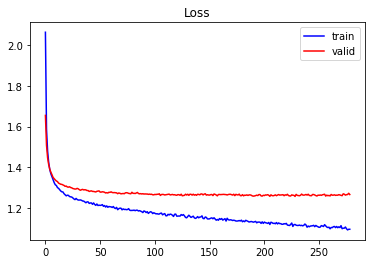

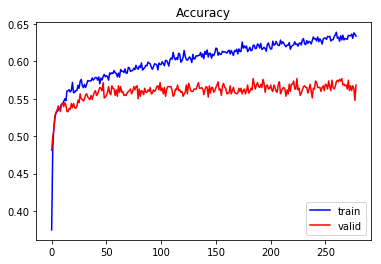

In [384]:
train_loss = model_history.history['loss']
train_acc = model_history.history['acc']
valid_loss = model_history.history['val_loss']
valid_acc = model_history.history['val_acc']
plt.plot(train_loss, 'b', label='train')
plt.plot(valid_loss, 'r', label='valid')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(train_acc, 'b', label='train')
plt.plot(valid_acc, 'r', label='valid')
plt.legend(loc=4)
plt.title("Accuracy")
plt.show()

In [385]:
y_predict = model.predict_classes(x_valid)
y_valid_label = np.argmax(y_valid.values, axis=1)
print('Accuracy in testing data:', accuracy_score(y_valid_label, y_predict))

Accuracy in testing data: 0.5682062298603652


In [386]:
#tf.global_variables()

In [387]:
# save model
model.save('my_model.h5')

# load model
another_model = tf.keras.models.load_model('my_model.h5')

In [388]:
y_predict = model.predict_classes(test)

In [389]:
data = list(zip(test_id, y_predict))
df = pd.DataFrame(data, columns=['ID', 'class'])
df.to_csv("20190827_at082022_submission.csv", index=0)
df.head()

,ID,class
0,MTA5MTEwOTYxMzM0NzA2NDEzNzM=,2
1,MTY0OTUyMTM2MDExMjg3MjczMjU=,1
2,MTQ0ODU1OTEzOTU1NTAyNzI4NjE=,4
3,MTY1ODg1MzEwNzYzNDUzMDUwNTM=,3
4,MTY0NTg2OTA5MTkzOTE2MTc1MTc=,5


In [214]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
y_label = train.loc[:, ['class']]
test_id = test.iloc[:, 0]
y_label_one_hot = my_one_hot_encoding(y_label.copy(), None, 'class')


if 'class' in train.columns:
    train = train.drop('class', axis=1)

if 'ID' in train.columns:
    train = train.drop('ID', axis=1)
    
if 'id' in test.columns:
    test = test.drop('id', axis=1)

train, test = my_std_normalization(train, test)
train, test = my_min_max_normalization(train, test)
train, test = my_boolean_encoding(train.copy(), test.copy())

one_hot_list = ['appearedTimeOfDay', 'city', 'continent', 'weather', 'weatherIcon']

for col in train.columns:
    if col in one_hot_list:
        train_col_one_hot, test_col_one_hot = my_one_hot_encoding(train.copy(), test.copy(), col)
        train = pd.concat([train, train_col_one_hot.iloc[:, 1:]], axis=1)
        test = pd.concat([test, test_col_one_hot.iloc[:, 1:]], axis=1)
        train = train.drop(col, axis=1)
        test = test.drop(col, axis=1)

        

        
x_train, x_valid, y_train, y_valid = train_test_split(train, y_label_one_hot, random_state = 22, test_size = 0.13, stratify=y_label)

In [215]:
another_model_history = another_model.fit(x=x_train, y=y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_valid, y_valid),
                          shuffle=False, callbacks=[early_stopping]
                         )

Train on 6229 samples, validate on 931 samples
Epoch 1/300
6229/6229 [==============================] - 0s 78us/step - loss: 1.2039 - acc: 0.6126 - val_loss: 1.1586 - val_acc: 0.6208
Epoch 2/300
6229/6229 [==============================] - 1s 85us/step - loss: 1.1835 - acc: 0.6211 - val_loss: 1.1611 - val_acc: 0.6079
Epoch 3/300
6229/6229 [==============================] - 1s 87us/step - loss: 1.1681 - acc: 0.6272 - val_loss: 1.1920 - val_acc: 0.5983
Epoch 4/300
6229/6229 [==============================] - 1s 87us/step - loss: 1.1557 - acc: 0.6272 - val_loss: 1.2127 - val_acc: 0.5961
Epoch 5/300
6229/6229 [==============================] - 1s 86us/step - loss: 1.1545 - acc: 0.6275 - val_loss: 1.2203 - val_acc: 0.5983
Epoch 6/300
6229/6229 [==============================] - 1s 85us/step - loss: 1.1544 - acc: 0.6288 - val_loss: 1.2445 - val_acc: 0.5822
Epoch 7/300
6229/6229 [==============================] - 1s 87us/step - loss: 1.1515 - acc: 0.6251 - val_loss: 1.2328 - val_acc: 0.5918
E

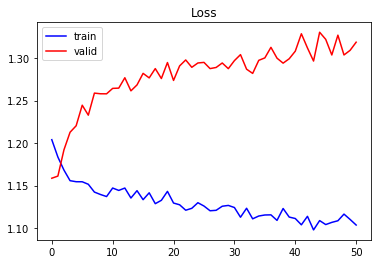

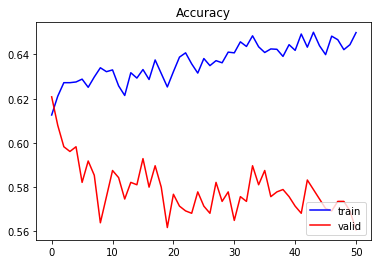

In [217]:
train_loss = another_model_history.history['loss']
train_acc = another_model_history.history['acc']
valid_loss = another_model_history.history['val_loss']
valid_acc = another_model_history.history['val_acc']
plt.plot(train_loss, 'b', label='train')
plt.plot(valid_loss, 'r', label='valid')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(train_acc, 'b', label='train')
plt.plot(valid_acc, 'r', label='valid')
plt.legend(loc=4)
plt.title("Accuracy")
plt.show()

In [218]:
y_predict = model.predict_classes(x_valid)
y_valid_label = np.argmax(y_valid.values, axis=1)
print('Accuracy in testing data:', accuracy_score(y_valid_label, y_predict))

Accuracy in testing data: 0.6616541353383458


In [219]:
y_predict = model.predict_classes(test)
data = list(zip(test_id, y_predict))
df = pd.DataFrame(data, columns=['ID', 'class'])
df.to_csv("20190827_at082022_submission.csv", index=0)
df.head()

,ID,class
0,MTA5MTEwOTYxMzM0NzA2NDEzNzM=,2
1,MTY0OTUyMTM2MDExMjg3MjczMjU=,1
2,MTQ0ODU1OTEzOTU1NTAyNzI4NjE=,4
3,MTY1ODg1MzEwNzYzNDUzMDUwNTM=,3
4,MTY0NTg2OTA5MTkzOTE2MTc1MTc=,5
